# Introduction

The notebook is intended to experiment with the TensorFlow Functional API to build a model.

In [1]:
# Import Standard Libraries
import os
import pandas as pd
import collections

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

In [2]:
# Notebook's variables
csv_columns  = ['fare_amount',
                'pickup_datetime',
                'pickup_longitude',
                'pickup_latitude',
                'dropoff_longitude',
                'dropoff_latitude',
                'passenger_count',
                'key']
features = ['pickup_longitude',
            'pickup_latitude',
            'dropoff_longitude',
            'dropoff_latitude',
            'passenger_count']
remove_columns = ['pickup_datetime', 'key']
label_column = 'fare_amount'
column_default_values = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]
train_batch_size = 32
test_batch_size = 1000
test_size = 10000

# Read Data

In [3]:
def map_feautres_and_labels(row_data: collections.OrderedDict):
    """
    Define the feature and label columns for a specific row in a TensorFlow Dataset

    Args:
        row_data: collections.OrderedDict row of data

    Returns:
        row_data: collections.OrderedDict row of features data
        label: collections.OrderedDict row of label data
    """
    
    # Fetch features to remove
    for remove_column in remove_columns:

        # Remove the feature
        row_data.pop(remove_column)

    # Remove the label columns
    label = row_data.pop(label_column)

    
    return row_data, label

In [4]:
def load_dataset(csv_path: str, 
                 batch_size: int, 
                 mode=tf.estimator.ModeKeys.EVAL):
    """
    Reads from a .CSV file and return a TensorFlow Dataset

    Args:
        csv_path: String path to the .CSV file
        batch_size: Integer number of samples per batch
        mode: tf.estimator.ModeKeys.EVAL | tf.estimator.ModeKeys.TRAIN dataset mode

    Returns:
        dataset = tf.Data.Dataset data prepared
    """

    # Load dataset
    dataset = tf.data.experimental.make_csv_dataset(csv_path, batch_size, csv_columns, column_default_values)

    # Create features and columns
    dataset = dataset.map(map_feautres_and_labels)

    # Shuffle data if in training mode
    if mode == tf.estimator.ModeKeys.TRAIN:

        dataset = dataset.shuffle(1000).repeat()

    # Prefetch
    dataset = dataset.prefetch(1)
                         
                     
    return dataset

In [5]:
# Create train and test datasets
train_dataset = load_dataset('./../../data/taxi_train.csv', train_batch_size, tf.estimator.ModeKeys.TRAIN)
test_dataset = load_dataset('./../../data/taxi_test.csv', test_batch_size, tf.estimator.ModeKeys.EVAL).take(test_size)

# Modeling

## Neural Network Architecture

In [6]:
# Define input layer for each feature column
# NOTE: This is used to ingest data with a certain shape
input_layer = {input_column: tf.keras.layers.Input(name=input_column, shape=(), dtype='float32') for input_column in features}

In [7]:
# Define the feature layer for each feature column
# NOTE: This is used to ensure the correct feature list
feature_layer = {feature_name: tf.feature_column.numeric_column(feature_name) for feature_name in features}

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [8]:
# Define the dense layer features
dense_inputs = tf.keras.layers.DenseFeatures(feature_layer.values())(input_layer) 

In [9]:
# Define hidden layers
dense_layer_1 = tf.keras.layers.Dense(32, activation='relu', name='dense_layer_1')(dense_inputs)
dense_layer_2 = tf.keras.layers.Dense(8, activation='relu', name='dense_layer_2')(dense_layer_1)

In [10]:
# Define output layer
output_layer = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(dense_layer_2)

In [11]:
# Create the model
model = tf.keras.models.Model(input_layer, output_layer)

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dropoff_latitude (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 passenger_count (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None,)]            0           []                               
                                                                                              

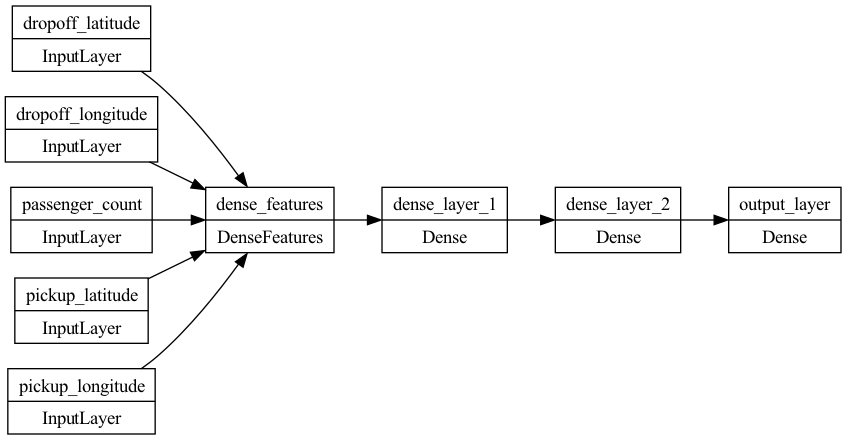

In [18]:
# Plot the Neural Network Architecture
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Training

In [ ]:
# Train the model
history = model.fit(train_dataset, 
                    validation_data=test_dataset,
                    epochs=32, 
                    steps_per_epoch=50)

Epoch 1/32
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x133c452d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x133c452d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: